In [1]:
import jax.numpy as jnp
from jax import random
from melvin import LaplaceApproximation
import jax
import matplotlib.pylab as plt
from functools import partial

jax.config.update("jax_enable_x64", True)

In [2]:
SEED = random.PRNGKey(220)
N_ROWS = 2000
LATENT_MEAN = 3.0
LATENT_STD = 1.0
NOISE_STD = 2.0

In [3]:
SEED, _seed_1, _seed_2 = random.split(SEED,3)
y_latent = jax.random.normal(key=_seed_1, shape=(N_ROWS,))*LATENT_STD + LATENT_MEAN
y = y_latent + jax.random.normal(key=_seed_2, shape=(N_ROWS,))*NOISE_STD

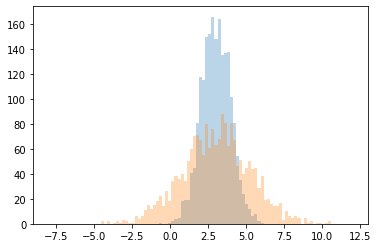

In [4]:
bins = jnp.linspace(-8,12,100)
plt.hist(y_latent, bins=bins, alpha=0.3)
plt.hist(y, bins=bins, alpha=0.3)
plt.show()

In [5]:
class GaussianDensityEstimator(LaplaceApproximation):
    param_bounds = jnp.array([[jnp.nan, jnp.nan], [0, jnp.nan]])

    def model(self, params, X):
        mu = params[0]
        std_latent = params[1]
        std_noise = self.fixed_params[0]
        std = jnp.sqrt(std_latent**2 + std_noise**2)
        return jnp.array([mu, std])

    def posterior_log_prob(self, y, y_pred, params):
        mu = y_pred[0]
        std = y_pred[1]
        log_like = jax.scipy.stats.norm.logpdf(y, loc=mu, scale=std)
        return jnp.sum(log_like)

initial_params = jnp.array([5.0, 5.0])

gaussian_density_estimator = GaussianDensityEstimator(
    name="Gaussian Density Estimator",
    initial_params=initial_params,
    fixed_params=jnp.array([NOISE_STD]),
    y=y
)
print(gaussian_density_estimator)

Laplace Approximation: Gaussian Density Estimator
Fixed Parameters: [2.]
Fit converged successfully
Fitted Parameters: 
[
  3.024761268266474 +/- 0.049949180142405486,
  0.9949076307863729 +/- 0.07930014213245747,	 [Lower Bound = 0.0]
]
Log Posterior Prob = -4445.281149570312


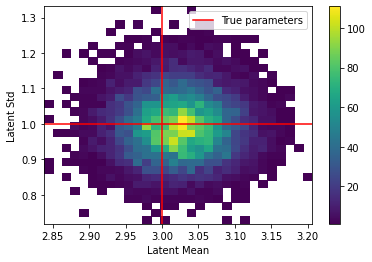

In [6]:
SEED, _seed = random.split(SEED,2)
samples = gaussian_density_estimator.sample_params(prng_key = _seed, n_samples = 10000, method="laplace")
plt.hist2d(samples[:,0], samples[:,1], bins=(30,30), cmin=1)
plt.axhline(LATENT_STD, color="r", label="True parameters")
plt.axvline(LATENT_MEAN, color="r")
plt.xlabel("Latent Mean")
plt.ylabel("Latent Std")
plt.colorbar()
plt.legend()
plt.show()

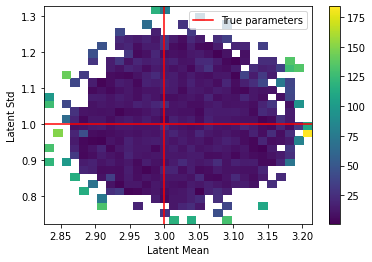

In [7]:
SEED, _seed = random.split(SEED,2)
importance_samples = gaussian_density_estimator.sample_params(prng_key = _seed, n_samples = 10000, method="gaussian_importance")
plt.hist2d(importance_samples[:,0], importance_samples[:,1], bins=(30,30), cmin=1)
plt.axhline(LATENT_STD, color="r", label="True parameters")
plt.axvline(LATENT_MEAN, color="r")
plt.xlabel("Latent Mean")
plt.ylabel("Latent Std")
plt.colorbar()
plt.legend()
plt.show()

In [8]:
print(gaussian_density_estimator.evaluate_samples(samples))
print(gaussian_density_estimator.evaluate_samples(importance_samples))


-4448.977628800283
-4451.128436688716


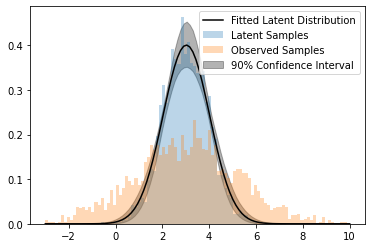

In [9]:
SEED, _seed = random.split(SEED,2)

def get_pdf(params, x):
    return jax.scipy.stats.norm.pdf(
        x, 
        loc=params[0], 
        scale=params[1]
    )

x = jnp.linspace(-3,10,100)
y_pdf = get_pdf(gaussian_density_estimator.params.x, x)

y_pdf_samples = gaussian_density_estimator.sample_params_map(
    prng_key = _seed, n_samples = 300, func=get_pdf, args=(x,), method="laplace"
    )
y_pdf_low = jnp.percentile(y_pdf_samples, q=5, axis=0)
y_pdf_upp = jnp.percentile(y_pdf_samples, q=95, axis=0)

plt.hist(y_latent, bins=x, alpha=0.3, density=True, label="Latent Samples")
plt.hist(y, bins=x, alpha=0.3, density=True, label="Observed Samples")
plt.plot(x, y_pdf, color="k", label="Fitted Latent Distribution")
plt.fill_between(x, y_pdf_low, y_pdf_upp, color="k", label="90% Confidence Interval", alpha=0.3)
plt.legend()
plt.show()